In [1]:
import ipyparallel as ipp

import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os
sys.path.append('/Users/zofia/github/DFM/srcDiffmap')

import mdtraj as md

import scipy.sparse.linalg as spsl

import integrator
import sampler #as sampler
import model #as model
# import diffusionmap as dm
# import statistics_dfm as stat

import numpy as np
from simtk import openmm, unit
# from openmmtools.constants import kB

from pydiffmap import diffusion_map as dmpy
import helpers
import model

In [277]:

methodName='frontier_points_corner_change_temperature_off_TMDmap_randomStart'


############################

#######################
# simulation temperature
T=300.0
# target temperature
T_target=300.0

metric_choice = 'euclidean'#'euclidean'#'rmsd'#

computeReference=0

if methodName=='std_ref':
    addReference=0
else:
    addReference=1

  
dataName='Data/'
folderName='/Users/zofia/github/DFM/'
modelName='Alanine'

dataFolderName = folderName+dataName+modelName+'/'+methodName

# results from this code will be saved here:
simulationFolder=folderName+dataName+'/TemporaryFigures_'+metric_choice+'/'+modelName+'/'+methodName



mdl=model.Model(modelName)
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())
# print (mdl.testsystem.positions)
# X0=mdl.testsystem.positions.value_in_unit(mdl.x_unit)



#mdl.testsystem.positions = IC


temperature =  T * unit.kelvin#300 * unit.kelvin
temperature_target =  T_target * unit.kelvin

gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

temperatureAlpha= (T)* unit.kelvin

# simulation class sampler takes integrator class with chosen parameters as input
intg=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')

#IC = md.load('alanine_start_state_IC.h5')
#smpl.integrator.x0 = IC.xyz * mdl.x_unit

# this will be used only to compare the target distributions
integrator_target=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature_target, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl_target=sampler.Sampler(model=mdl, integrator=integrator_target, algorithm=0, dataFileName='Data')

newpath = os.path.join(os.getcwd(),simulationFolder)
if not os.path.exists(newpath):
        os.makedirs(newpath)

        
#print(IC.xyz * mdl.x_unit==smpl.integrator.x0)



Maximal position value in one direction is 0.86477354000000006
PBC box size set to 8.6477354000000002
nanometer
System has 22 particle(s)
834.248140571 K
727.562446057 K


[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4
  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9
 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14
 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 19 19 19
 20 20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23 24 24 24 24 24
 25 25 25 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28 28 29 29 29 29 29
 30 30 30 30 30 31 31 31 31 31 32 32 32 32 32 33 33 33 33 33 34 34 34 34 34
 35 35 35 35 35 36 36 36 36 36 37 37 37 37 37 38 38 38 38 38]


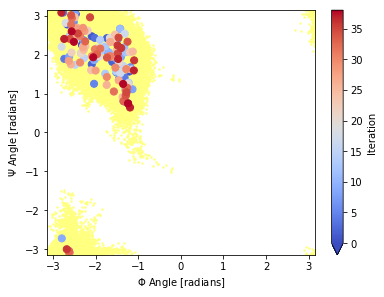

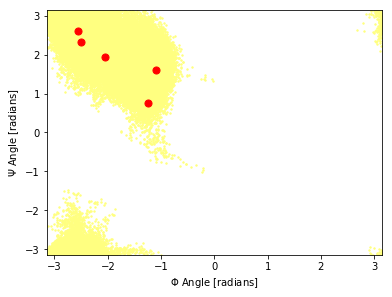

In [278]:
def plotSamplingDihedrals(nameData, nameFrontier, samplerAlgo, numberOfFrontierPoints, methodName,singleDataFrame=False):
    
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    top=md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
    X_FT = helpers.loadData(nameData, top, modnr)
    inp=md.Trajectory(X_FT, top)

    angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    
    ax.scatter(angles[:, 0], angles[:, 1], s=2, c=[1,1,0.5]);
            
    X_frontier = helpers.loadData(nameFrontier, top, modnr)
    inpFrontierPoints = md.Trajectory(X_frontier, top)
    anglesFrontierPoints = md.geometry.compute_dihedrals(inpFrontierPoints, [phi_indices, psi_indices]) 
         
    nrIt = int(len(anglesFrontierPoints) / numberOfFrontierPoints)
    colfp = np.asarray(range(0,nrIt))
    cfp=list()
    for i in range(numberOfFrontierPoints):
        cfp.append(colfp)
    cfarr=(np.asarray(cfp).transpose())
    cfarr=cfarr.reshape(len(anglesFrontierPoints))
    print(cfarr)
    #print(len(angles))
    axfp = ax.scatter(anglesFrontierPoints[:, 0], anglesFrontierPoints[:, 1], s=50, c = cfarr, cmap ='coolwarm',vmin=0, vmax=cfarr.max());
    
    cbar = plt.colorbar(axfp,extend='min')

    cbar.set_label('Iteration')
    #ax.set_title('Alanine dipeptide ')
    ax.set_xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-np.pi, np.pi)
    ax.set_ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-np.pi, np.pi)
    
    plt.savefig(dataFolderName+'/corner_points'+methodName+'.eps')#,  format='eps', dpi=1000, bbox_inches='tight')
    plt.show()
    
    
    ##########################
    
    fig2 = plt.figure(figsize=(6,4.5))
    ax2 = fig2.add_subplot(111)
    
    ax2.scatter(angles[:, 0], angles[:, 1], s=2, c=[1,1,0.5]);
    ax2.scatter(anglesFrontierPoints[-(numberOfFrontierPoints)-1:-1, 0], anglesFrontierPoints[-(numberOfFrontierPoints)-1:-1, 1], s=50, c = 'r')
    
    ax2.set_xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-np.pi, np.pi)
    ax2.set_ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-np.pi, np.pi)
    
    plt.savefig(dataFolderName+'/last_it_corner_points'+methodName+'.eps')#,  format='eps', dpi=1000, bbox_inches='tight')
    plt.show()

numberOfFrontierPoints=5 #
plotSamplingDihedrals(dataFolderName+'/Traj/*.h5', dataFolderName+'/Traj/FrontierPoints/'+'*.h5',  smpl, numberOfFrontierPoints, methodName)

In [186]:
dataFolderName

'/Users/zofia/github/DFM/Data/Alanine/local_frontier_points'

In [93]:
def compute_dihedrals_phi(X_FT):
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    
    inp=md.Trajectory(X_FT, md.Topology().from_openmm(smpl.model.testsystem.topology))

    Y = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
    return Y[:,0]

def compute_dihedrals_psi(X_FT):
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    
    inp=md.Trajectory(X_FT, md.Topology().from_openmm(smpl.model.testsystem.topology))

    Y = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
    return Y[:,1]

colective_variable = compute_dihedrals_psi
cv_name = 'Dihedral angle psi'




Loaded trajectory of length 5000


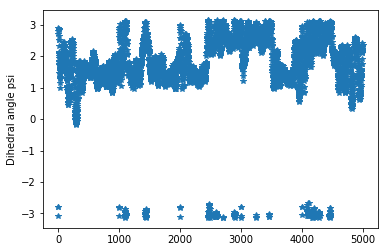

In [94]:
if metric_choice == 'rmsd':
    al = False
elif metric_choice == 'euclidean':
    al = False

modnr=1
X_FT = helpers.loadData(dataFolderName+'/Traj/*.h5', mdl.testsystem.topology, modnr, align=al)
print('Loaded trajectory of length '+repr(X_FT.shape[0]))
# X_FT =X_FT[:finalLength]
# print('Final lenght of trajectory is '+repr(X_FT.shape[0]))
# X_FT=X_FT[::modnr]
# print('After subsampling, the data length is '+repr(len(X_FT)))

#compute collective variable
r=colective_variable(X_FT)
cv=r

plt.plot(range(len(r)), r, '*')
plt.ylabel(cv_name)
plt.savefig(simulationFolder+'/colvar.png')

plt.show()

In [95]:
# # save reference simulation
# def compute_free_energy(cv, weights=None, nrbins=100):


#     pi_marginal, bin_edges = np.histogram(cv, bins = nrbins, weights = weights, density=True)
#     bin_widths = bin_edges[1:] - bin_edges[:-1]
#     bin_centers = bin_edges[:-1] + 0.5*bin_widths
#     free_energy= - np.log(pi_marginal)

#     return free_energy, bin_centers

# nrBins=100

# print('Computing collective variable of trajectory of  '+repr(len(X_FT))+' points')
# cv=colective_variable(X_FT)

# free_energy_300_ref, bin_centers_300_ref = compute_free_energy(cv, nrbins = nrBins)

# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111)
# ax.scatter(bin_centers_300_ref, free_energy_300_ref, s=5, c='b', marker='o')
# #ax.scatter(bc_ref, FE_ref, s=5, c='r', marker='o')
# plt.legend({methodName, '300K'})
# ax.set_xlabel(cv_name)
# ax.set_ylabel('Free energy [kT]')
# plt.show()

# # load reference free energy profile at 300 K
# reference_folder_300K='/Users/zofia/github/DFM/Results/Alanine/T300/'

# #np.save(reference_folder_300K+ 'reference_alanine_300K_1fs_FE_phi.npy')
# #np.save(reference_folder_300K+ 'reference_alanine_300K_1fs_bins_phi.npy')

(5, 5000, 2)


/Users/zofia/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


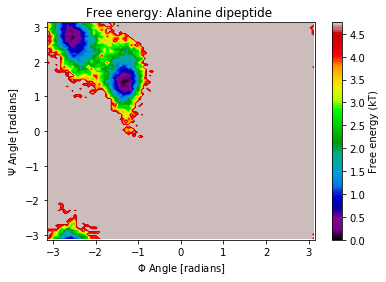

In [97]:
pyEmmaPlot=1
if pyEmmaPlot:
    
    numberOfIterations = 5
    import pyemma.coordinates as coor
    feat = coor.featurizer(md.Topology().from_openmm(smpl.model.testsystem.topology))
    feat.add_backbone_torsions()
    inp=[coor.load(dataFolderName+'/Traj/Alaninetraj_'+repr(i)+'.h5', feat, stride=1) for i in range(0,numberOfIterations)]
    #inp=[coor.load(dataFolderName+'/shortTraj.h5', feat, stride=1) ]
    print( np.asarray(inp).shape)
    
    
    import pyemma.plots as mplt
    from math import pi

    Y = inp   

    mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);
    plt.title('Free energy: Alanine dipeptide ')
    plt.xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-pi, pi)
    plt.ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-pi, pi)
    #plt.savefig('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/freeEnergy.png', dpi='figure', bbox_inches='tight')
    plt.savefig('enhanced.eps')
    plt.show()

In [7]:
# load reference free energy profile at 300 K
reference_folder_300K='/Users/zofia/github/DFM/Results/Alanine/T300/'

FE_ref = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_FE.npy')
bc_ref = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_bins.npy')

In [8]:
def compute_free_energy(cv, weights=None, nrbins=100):


    pi_marginal, bin_edges = np.histogram(cv, bins = nrbins, weights = weights, density=True)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    bin_centers = bin_edges[:-1] + 0.5*bin_widths
    free_energy= - np.log(pi_marginal)

    return free_energy, bin_centers

Computing collective variable of trajetory of  13500 points


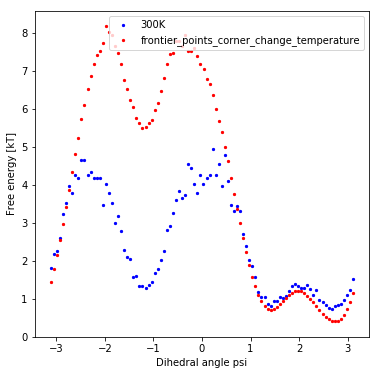

In [9]:
nrBins=100

print('Computing collective variable of trajetory of  '+repr(len(X_FT))+' points')
cv=colective_variable(X_FT)

free_energy_400_ref, bin_centers_400_ref = compute_free_energy(cv, nrbins = nrBins)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(bin_centers_400_ref, free_energy_400_ref, s=5, c='b', marker='o')
ax.scatter(bc_ref, FE_ref, s=5, c='r', marker='o')
plt.legend({methodName, '300K'})
ax.set_xlabel(cv_name)
ax.set_ylabel('Free energy [kT]')
plt.show()

In [10]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
#from MDAnalysis.tests.datafiles import PSF, DCD, PDB_small

trj = mda.Universe('/Users/zofia/github/DFM/alanine-ff96.pdb', X_FT) 
print(trj.trajectory)
ref = mda.Universe('/Users/zofia/github/DFM/alanine-ff96.pdb')#, X_FT[0,:,:]) 
#print(ref)
alignment = align.AlignTraj(trj, trj)#, filename='rmsfit.dcd')
alignment.run()
X_aligned = np.zeros(X_FT.shape)
ci=0
for ts in trj.trajectory:
    X_aligned[ci] = trj.trajectory.ts.positions
    ci=ci+1
    
#X_aligned = (trj.trajectory.positions)
print(X_aligned.shape)
print(alignment)
X_FT=X_aligned

/Users/zofia/miniconda3/lib/python3.6/site-packages/MDAnalysis/__init__.py:245: UserWarning: #####
MDAnalysis on python 3 is highly experimental!
It is mostly non functional and dramatically untested.
Use at your own risks!!!

  ''')


<MemoryReader with 13500 frames of 22 atoms>
(13500, 22, 3)


In [ ]:
metric_choice = 'euclidean'


In [ ]:
# methodName='T300/std'#'T300/frontier_points_corner_eucl_increase800K'#frontier_points_corner_rmsd_increaseT400'#frontier_points_corner_euclidean'#'frontier_points_corner'#'frontier_points_corner'#
# modnr = 1
# metric_choice = 'euclidean'
# dataFolderName=folderName+dataName+modelName+'/'+methodName

# if metric_choice == 'rmsd':
#     al = False
# elif metric_choice == 'euclidean':
#     al = False

# # for short traj- load from dataFolderName+'/shortTraj.h5'
# #X_FT =helpers.loadData(dataFolderName+'/shortTraj.h5', mdl.testsystem.topology, modnr, align=False)
# X_FT = helpers.loadData(dataFolderName+'/Traj/*.h5', mdl.testsystem.topology, modnr, align=al)
# print('Loaded trajectory of length '+repr(X_FT.shape[0]))


# #compute collective variable
# cv=colective_variable(X_FT)

# plt.plot(range(len(cv)), cv)
# plt.ylabel(cv_name)
# plt.savefig(simulationFolder+'/colvar.png')

# plt.show()

In [ ]:
#trjSave=md.Trajectory(X_FT, smpl.model.testsystem.topology)
#trjSave.save_hdf5(dataFolderName+'/shortTraj.h5')

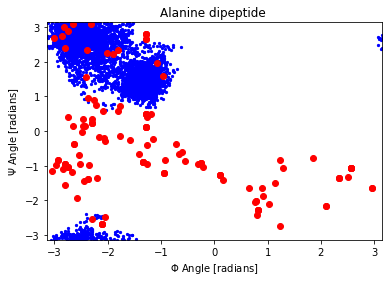

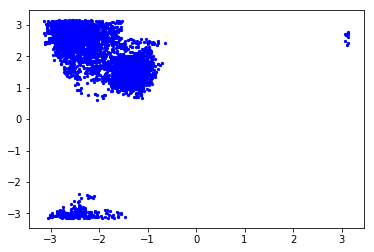

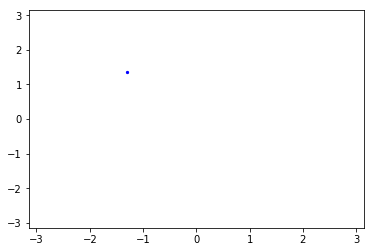

In [26]:
#openmm.app.PDBFile.writeFile(smpl.model.testsystem.topology, X_FT[0], open('alanine.pdb', 'w'))
plotSamplingDihedrals(dataFolderName+'/Traj/Alaninetraj_1.h5', dataFolderName+'/Traj/FrontierPoints/'+'*.h5', smpl)

X_transition = helpers.loadData(dataFolderName+'/Traj/Alaninetraj_1.h5', mdl.testsystem.topology, modnr, align=al)

psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
top=md.Topology().from_openmm(smpl.model.testsystem.topology)
inp_start=md.Trajectory(X_transition, top)

angles = md.geometry.compute_dihedrals(inp_start, [phi_indices, psi_indices]) 
plt.scatter(angles[:, 0], angles[:, 1], s=5, c='b');
plt.show()

idx = (np.argwhere(angles[:, 0]<1.5))
idx =np.argwhere(angles[idx, 0]>0)
idx =np.argwhere(angles[idx, 1]>-2)
idx = np.argwhere( angles[idx, 1]<0)

plt.scatter(angles[-10, 0], angles[-10, 1], s=5, c='b');
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.show()

#inp_start[-100].save_pdb('alanine_start_state_IC.pdb')
#openmm.app.PDBFile.wr iteFile(smpl.model.testsystem.topology, X_transition[-1], open('alanine_start_state2.pdb', 'w'))

In [15]:
#inp_start[-1].save_hdf5('alanine_start_state_IC.h5')

In [37]:



# openmm.app.PDBFile.writeFile(smpl.model.testsystem.topology, X_FT[0], open('alanine.h5', 'w'))



# import MDAnalysis as mda
# from MDAnalysis.analysis import align
# from MDAnalysis.analysis.rms import rmsd
# #from MDAnalysis.tests.datafiles import PSF, DCD, PDB_small

# #trj = mda.Universe('/Users/zofia/github/DFM/alanine-ff96.pdb', X_FT) 
# trj = mda.Universe('alanine.pdb', X_FT) 
# #print(trj.trajectory)
# #ref = mda.Universe('/Users/zofia/github/DFM/alanine-ff96.pdb')#, X_FT[0,:,:]) 
# print(ref)
# # trj = mda.Universe('/Users/zofia/github/DFM/alanine.xyz', X_FT) 
# # print(trj.trajectory)
# # ref = mda.Universe('/Users/zofia/github/DFM/alanine.xyz')#, X_FT[0,:,:]) 


# alignment = align.AlignTraj(trj, trj)#, filename='rmsfit.dcd')
# alignment.run()
# X_aligned = np.zeros(X_FT.shape)
# ci=0
# for ts in trj.trajectory:
#     X_aligned[ci] = trj.trajectory.ts.positions
#     ci=ci+1
    
# #X_aligned = (trj.trajectory.positions)
# print(X_aligned.shape)
# print(alignment)
# X_FT=X_aligned

In [38]:
#md.Trajectory(X_FT[:10], mdl.testsystem.topology).save_dcd('/Users/zofia/github/DFM/Results/Alanine/T300/std_ref/traj.dcd')

In [39]:
# pyEmmaPlot=1
# if pyEmmaPlot:
    
#     numberOfIterations = 75# 1350
#     import pyemma.coordinates as coor
#     feat = coor.featurizer(md.Topology().from_openmm(smpl.model.testsystem.topology))
#     feat.add_backbone_torsions()
#     inp=[coor.load(dataFolderName+'/Traj/Alaninetraj_'+repr(i)+'.h5', feat, stride=1) for i in range(0,numberOfIterations)]
#     #inp=[coor.load(dataFolderName+'/shortTraj.h5', feat, stride=1) ]
#     print( np.asarray(inp).shape)
    
    
#     import pyemma.plots as mplt
#     from math import pi

#     Y = inp   

#     mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);
#     plt.title('Free energy: Alanine dipeptide ')
#     plt.xlabel(r'$\Phi$ Angle [radians]')
#     plt.xlim(-pi, pi)
#     plt.ylabel(r'$\Psi$ Angle [radians]')
#     plt.ylim(-pi, pi)
#     #plt.savefig('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/freeEnergy.png', dpi='figure', bbox_inches='tight')

#     plt.show()
   




Get the target density at sampled data points
... might take a while ...
Done
Done


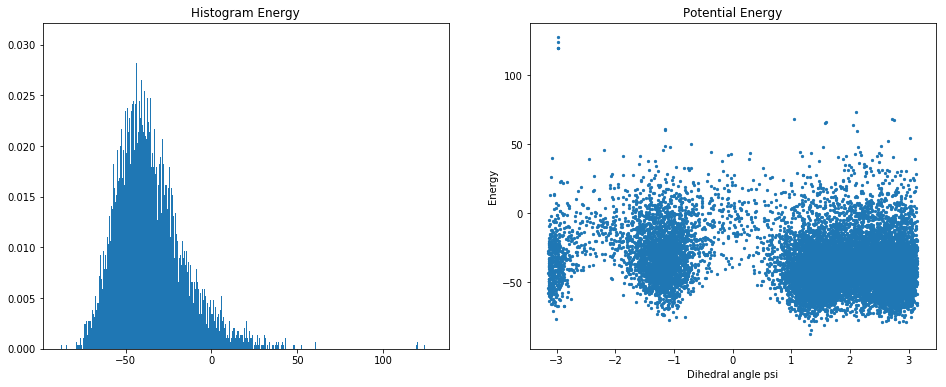

In [11]:

print('Get the target density at sampled data points')
print('... might take a while ...')

"""
target density: exp(-beta V(q)) : [V(q)] = kilojoule/mole, [beta] =  J/mol
"""

E = helpers.computeEnergy(X_FT, smpl)

qTargetDistribution= helpers.computeTargetMeasure(X_FT, smpl, E)
qTargetDistribution_targetTemperature = helpers.computeTargetMeasure(X_FT, smpl_target, E)


fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
cax = ax.hist(E, 1000, normed=True)
ax.set_title('Histogram Energy')


ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(colective_variable(X_FT), E ,s=5 )
ax2.set_xlabel(cv_name)
ax2.set_ylabel('Energy')
ax2.set_title('Potential Energy')

fig.savefig(simulationFolder+'/energy.png')

plt.show()

In [12]:
metric_choice = 'euclidean'
compute_spectral_decomposition=1

In [13]:
################ diffusion diffmaps
if metric_choice == 'euclidean':
    epsilon=0.1

    Xresh=X_FT.reshape(X_FT.shape[0], X_FT.shape[1]*X_FT.shape[2])

    
    if compute_spectral_decomposition==0:
        my_kernel = dmpy.kernel.Kernel(kernel_type='gaussian', k=1000,
                                  epsilon=epsilon,
                                  metric='euclidean')
        my_kernel.fit(Xresh)
        
        K=my_kernel.compute(Xresh)
        q = np.array(K.sum(axis=1)).ravel()
    else:
        mydmap = dmpy.DiffusionMap(alpha = 1, n_evecs = 1, epsilon = epsilon,  k=1000, metric='euclidean')#, neighbor_params = {'n_jobs':-4})    
        dmap = mydmap.fit_transform(Xresh, weights = qTargetDistribution_targetTemperature)

        P = mydmap.P
        evals = mydmap.evals
        evecs = mydmap.evecs

        [evalsT, evecsT] = spsl.eigs(P.transpose(),k=1, which='LM')
        phi = np.real(evecsT.ravel())

        q = mydmap.q

In [14]:
if metric_choice == 'rmsd':
    import scipy.sparse as sps

    traj = md.Trajectory(X_FT, mdl.testsystem.topology)

    indptr = [0]
    indices = []
    data = []
    k = 1000
    epsilon =1

    for i in range(traj.n_frames):
        # compute distances to frame i
        distances = md.rmsd(traj, traj, i)
        # this performs a partial sort so that idx[:k] are the indices of the k smallest elements
        idx = np.argpartition(distances, k)
        # retrieve corresponding k smallest distances
        distances = distances[idx[:k]]
        # append to data structure
        data.extend(np.exp(-1.0/epsilon*distances**2).tolist())
        indices.extend(idx[:k].tolist())
        indptr.append(len(indices))

    kernel_matrix = sps.csr_matrix((data, indices, indptr), dtype=float, shape=(traj.n_frames, traj.n_frames))

    # this is all stolen from pydiffmap
    weights_tmdmap = qTargetDistribution_targetTemperature

    alpha = 1.0
    q = np.array(kernel_matrix.sum(axis=1)).ravel()
    # Apply right normalization
    right_norm_vec = np.power(q, -alpha)
    if weights_tmdmap is not None:
        right_norm_vec *= np.sqrt(weights_tmdmap)

    m = right_norm_vec.shape[0]
    Dalpha = sps.spdiags(right_norm_vec, 0, m, m)
    kernel_matrix = kernel_matrix * Dalpha

    # Perform  row (or left) normalization
    row_sum = kernel_matrix.sum(axis=1).transpose()
    n = row_sum.shape[1]
    Dalpha = sps.spdiags(np.power(row_sum, -1), 0, n, n)
    P = Dalpha * kernel_matrix

    n_evecs = 2

    evals, evecs = spsl.eigs(P, k=(n_evecs+1), which='LM')
    ix = evals.argsort()[::-1][1:]
    evals = np.real(evals[ix])
    evecs = np.real(evecs[:, ix])
    dmap = np.dot(evecs, np.diag(evals))

    [evalsT, evecsT] = spsl.eigs(P.transpose(),k=1, which='LM')
    phi = np.real(evecsT.ravel())

    fig = plt.figure(figsize=(6,6))
    plt.scatter(cv, evecs[:,0], s=5)
    plt.xlabel('Radius')
    plt.ylabel('Dominant eigenvector')
    plt.show()

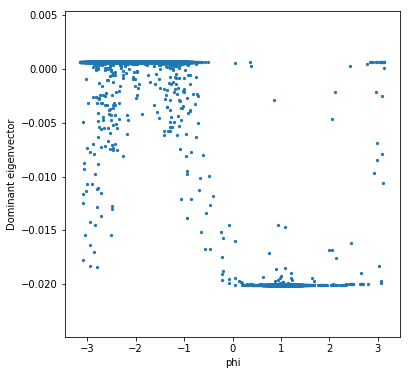

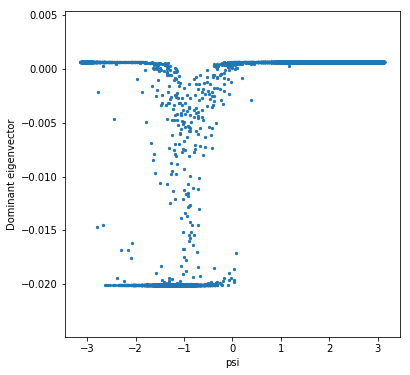

In [15]:
if compute_spectral_decomposition==1:
    #cv=compute_dihedrals_psi(X_FT)
    cv=compute_dihedrals_phi(X_FT)

    fig = plt.figure(figsize=(6,6))
    plt.scatter(cv, evecs[:,0], s=5)
    plt.xlabel('phi')
    plt.ylabel('Dominant eigenvector')
    plt.show()

    #cv=compute_dihedrals_psi(X_FT)
    cv=compute_dihedrals_psi(X_FT)

    fig = plt.figure(figsize=(6,6))
    plt.scatter(cv, evecs[:,0], s=5)
    plt.xlabel('psi')
    plt.ylabel('Dominant eigenvector')
    plt.show()

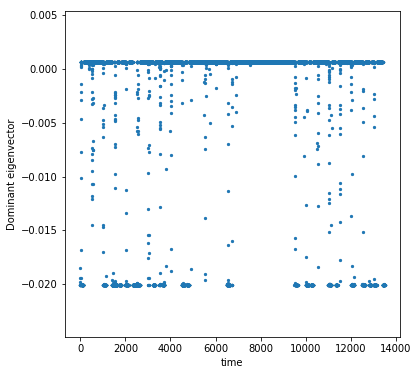

In [16]:
if compute_spectral_decomposition==1:
    #cv=compute_dihedrals_psi(X_FT)
    cv=colective_variable(X_FT)

    fig = plt.figure(figsize=(6,6))
    plt.scatter(range(len(evecs[:,0])), evecs[:,0], s=5)
    plt.xlabel('time')
    plt.ylabel('Dominant eigenvector')
    plt.show()

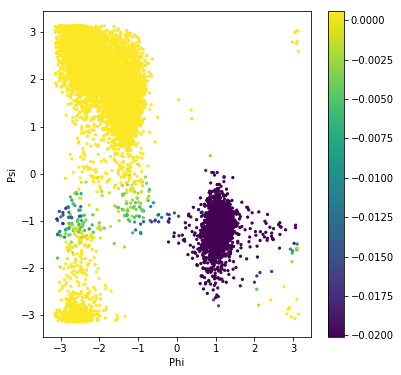

In [17]:
if compute_spectral_decomposition==1:
    #cv=compute_dihedrals_psi(X_FT)
    cv_phi=compute_dihedrals_phi(X_FT)
    cv_psi=compute_dihedrals_psi(X_FT)

    fig = plt.figure(figsize=(6,6))
    plt.scatter(cv_phi, cv_psi, c=evecs[:,0], s=5)
    cbar=plt.colorbar()
    plt.xlabel('Phi')

    plt.ylabel('Psi')
    plt.show()

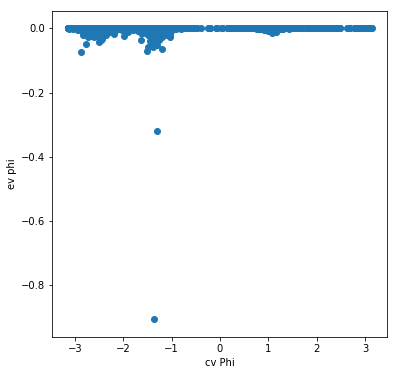

In [18]:
if compute_spectral_decomposition==1:
    #cv=compute_dihedrals_psi(X_FT)
    cv_phi=compute_dihedrals_phi(X_FT)
    cv_psi=compute_dihedrals_psi(X_FT)

    fig = plt.figure(figsize=(6,6))
    plt.scatter(cv_phi, phi)#, c=evecs[:,0], s=5)
    #plt.scatter(cv_phi, qTargetDistribution_targetTemperature/q)
    #cbar=plt.colorbar()
    plt.xlabel('cv Phi')

    plt.ylabel('ev phi')
    plt.show()

In [19]:
if compute_spectral_decomposition==1:
    # estimated density by KDE
    #q_est = q*phi#mydmap.q
    q_est = q*phi
    q_estNormalized = q_est/sum(q_est)

    qTargetDistributionNormalized = qTargetDistribution/sum(qTargetDistribution)
    print("Error on the density: "+repr(np.linalg.norm(q_estNormalized - qTargetDistributionNormalized,1)))

    weight =  qTargetDistribution_targetTemperature/q

qTargetDistribution_targetTemperature = qTargetDistribution_targetTemperature/sum(qTargetDistribution_targetTemperature)

Error on the density: 1.0441708000955461


/Users/zofia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


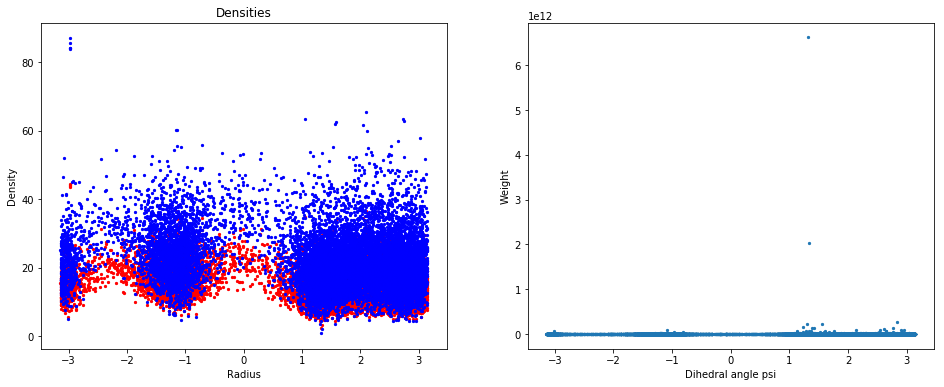

In [20]:
if compute_spectral_decomposition==1:
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(121)
    ax.scatter(cv, -np.log(q_estNormalized), s=5, c='r')
    ax.scatter(cv, -np.log(qTargetDistribution_targetTemperature), s=5, c='b')
    ax.set_xlabel('Radius')
    ax.set_ylabel('Density')


    ax.set_title('Densities')


    ax2 = fig.add_subplot(122)
    cax2 = ax2.scatter(cv, weight  ,s=5 )
    ax2.set_xlabel(cv_name)
    ax2.set_ylabel('Weight')
    #ax2.set_title('Potential Energy')

    fig.savefig(simulationFolder+'/KDE_weight.png')


    plt.show()

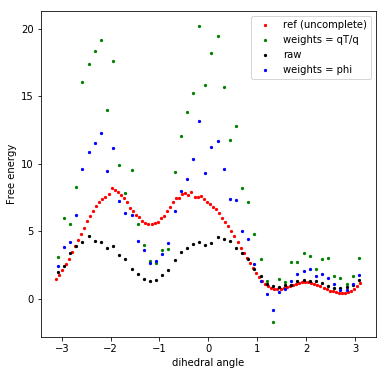

In [21]:
weight = qTargetDistribution_targetTemperature/q
cv=compute_dihedrals_psi(X_FT)

free_energy_raw, bin_centers_raw = compute_free_energy(cv, nrbins = 50)
free_energy_unbiased, bin_centers_unb = compute_free_energy(cv, nrbins = 50, weights=weight)
if compute_spectral_decomposition==1:
    free_energy_unbiased2, bin_centers_unb2 = compute_free_energy(cv, nrbins = 50, weights=phi)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(bc_ref, FE_ref, s=5, c='r', marker='o')
ax.scatter(bin_centers_unb, free_energy_unbiased, s=5, c='g', marker='o')
ax.scatter(bin_centers_raw, free_energy_raw, s=5, c='k', marker='o')
if compute_spectral_decomposition==1:
    ax.scatter(bin_centers_unb2, free_energy_unbiased2, s=5, c='b', marker='o')
ax.set_xlabel('dihedral angle')
ax.set_ylabel('Free energy')
#ax.set_ylim([0,10])
ax.legend(['ref (uncomplete)','weights = qT/q', 'raw','weights = phi'])
plt.show()